# Loading Data and Dependencies

In [1]:
#Import all dependencies
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Create data dir and download csv into it
url <- "https://raw.githubusercontent.com/21chanas3/dsci100-group73/c9c58b88eca13be20286f8bf70dce4668b878247/data/healthcare-dataset-stroke-data.csv"
if (!dir.exists("data")) {
    dir.create("data")
}
download.file(url, "data/stroke.csv")

In [3]:
stroke <- read_csv("data/stroke.csv")

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Cleaning and Wrangling

In [4]:
#Rename columns to all lowercase
stroke_colnames <- stroke |> colnames() |> make.names() |> tolower()
colnames(stroke) <- stroke_colnames

In [8]:
#Convert Unknown's to NA
stroke <- stroke |> na_if("Unknown")

#Convert categorical vars to factors
stroke <- stroke |> mutate(gender = as_factor(gender), 
                 work_type = as_factor(work_type), 
                 residence_type = as_factor(residence_type), 
                 smoking_status = as_factor(smoking_status),
                 hypertension = as_factor(hypertension),
                 ever_married = as_factor(ever_married),
                 heart_disease = as_factor(heart_disease),
                 stroke = as_factor(stroke))

#Rename factor levels to nicer names
stroke$hypertension <- recode_factor(stroke$hypertension, "0" = "No", "1" = "Yes")
stroke$heart_disease <- recode_factor(stroke$hypertension, "0" = "No", "1" = "Yes")
stroke$stroke <- recode_factor(stroke$hypertension, "0" = "No", "1" = "Yes")
stroke$work_type <- recode_factor(stroke$work_type, "Govt_job" = "Government", "Never_worked" = "Never Worked")
stroke$smoking_status <- recode_factor(stroke$smoking_status, "formerly smoked" = "Formerly", "never smoked" = "Never", "smokes" = "Smokes")

In [9]:
#For some reason bmi is of type char probably because of N/A, converting to double here
stroke <- stroke |> mutate(bmi = as.numeric(as.character(bmi)))

In [12]:
#Creating test/train split here
stroke_split <- initial_split(stroke, prop = 0.8, strata = stroke)
stroke_training <- training(stroke_split)
stroking_testing <- testing(stroke_split)

In [13]:
#Getting summary stats for categorical vars here
stroke_gender_stats <- stroke_training |> group_by(gender) |> summarise(value = n()) |> 
    rename("key" = "gender") |> mutate(column_name = "gender")
stroke_ever_married_stats <- stroke_training |> group_by(ever_married) |> summarise(value = n()) |> 
    rename("key" = "ever_married") |> mutate(column_name = "ever_married")
stroke_work_type_stats <- stroke_training |> group_by(work_type) |> summarise(value = n()) |> 
    rename("key" = "work_type") |> mutate(column_name = "work_type")
stroke_residence_type_stats <- stroke_training |> group_by(residence_type) |> summarise(value = n()) |> 
    rename("key" = "residence_type") |> mutate(column_name = "residence_type")
stroke_smoking_status_stats <- stroke_training |> group_by(smoking_status) |> summarise(value = n()) |> 
    rename("key" = "smoking_status") |> mutate(column_name = "smoking_status")
stroke_hypertension_stats <- stroke_training |> group_by(hypertension) |> summarise(value = n()) |> mutate(hypertension = as.character(hypertension)) |> 
    rename("key" = "hypertension") |> mutate(column_name = "hypertension") 
stroke_heart_disease_stats <- stroke_training |> group_by(heart_disease) |> summarise(value = n()) |> mutate(heart_disease = as.character(heart_disease)) |> 
    rename("key" = "heart_disease") |> mutate(column_name = "heart_disease")
stroke_stroke_stats <- stroke_training |> group_by(stroke) |> summarise(value = n()) |> mutate(stroke = as.character(stroke)) |> 
    rename("key" = "stroke") |> mutate(column_name = "stroke") 

In [14]:
#Getting summary stats for continuous vars here
stroke_numeric_cols_summary <- stroke |> 
    select(avg_glucose_level, bmi, age) |> 
    map_dfc(mean, na.rm = TRUE)

In [15]:
#Combining both summary stats
stroke_summary_stats <- stroke_numeric_cols_summary |> pivot_longer(age:avg_glucose_level, names_to = "column_name", values_to = "value")
stroke_summary_stats <- stroke_summary_stats |> mutate(key = "mean")
stroke_summary_stats <- bind_rows(stroke_summary_stats, 
                                  stroke_gender_stats, 
                                  stroke_ever_married_stats, 
                                  stroke_work_type_stats,
                                  stroke_residence_type_stats,
                                  stroke_smoking_status_stats,
                                  stroke_stroke_stats,
                                  stroke_hypertension_stats,
                                  stroke_heart_disease_stats)
stroke_summary_stats <- stroke_summary_stats[, c(1,3,2)]
stroke_summary_stats |> as_tibble() |> print(n = 25)


# A tibble: 25 × 3
   column_name       key            value
   <chr>             <chr>          <dbl>
 1 age               mean            43.2
 2 bmi               mean            28.9
 3 avg_glucose_level mean           106. 
 4 gender            Male          1682  
 5 gender            Female        2405  
 6 gender            Other            1  
 7 ever_married      Yes           2695  
 8 ever_married      No            1393  
 9 work_type         Government     526  
10 work_type         Never Worked    19  
11 work_type         Private       2366  
12 work_type         Self-employed  644  
13 work_type         children       533  
14 residence_type    Urban         2057  
15 residence_type    Rural         2031  
16 smoking_status    Formerly       710  
17 smoking_status    Never         1510  
18 smoking_status    Smokes         637  
19 smoking_status    NA            1231  
20 stroke            No            3683  
21 stroke            Yes            405  
22 hypertension

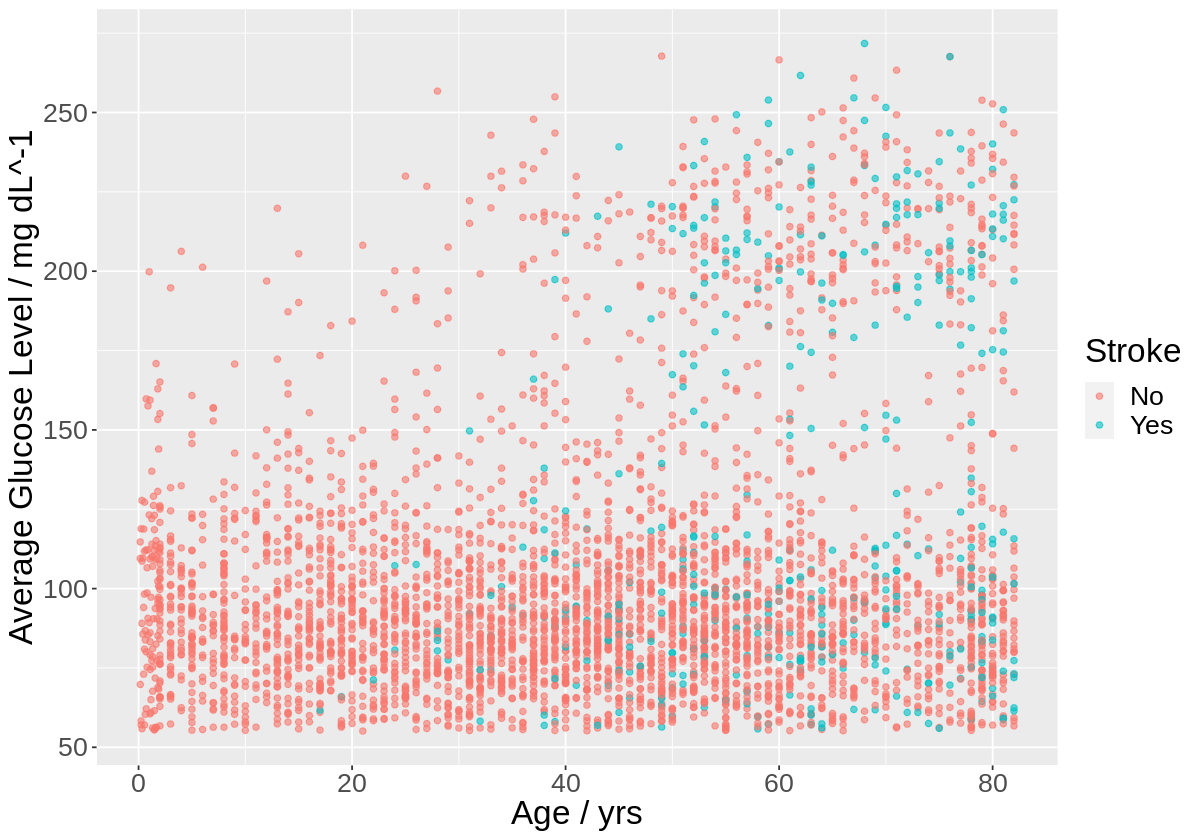

In [16]:
#Create visualization
options(repr.plot.width = 10, repr.plot.height = 7)
stroke_prelim_vis <- stroke_training |> ggplot(aes(x = age, y = avg_glucose_level, color = stroke)) + 
    geom_point(alpha = 0.6) +
    labs(x = "Age / yrs", y = "Average Glucose Level / mg dL^-1", color = "Stroke") +
    theme(text = element_text(size = 20))
stroke_prelim_vis